# Segmentação do Oxford-IIIT Pet Dataset com DeepLabV3+

## 1. Configuração e Imports

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
from tqdm.notebook import tqdm # Barra de progresso para notebooks
from sklearn.metrics import confusion_matrix
import os # Para gerenciar diretórios de dados
import pandas as pd

print("Bibliotecas importadas.")
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Datasets version: {tfds.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Bibliotecas importadas.
TensorFlow version: 2.18.0
TensorFlow Datasets version: 4.9.8
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [17]:
IMG_SIZE = (256, 256)
NUM_CLASSES_BINARY = 2
N_VISUALIZE = 5
EVAL_SAMPLE_SIZE = 150

preprocess_img = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(), # Converte PIL Image (H, W, C) [0, 255] para Tensor (C, H, W) [0.0, 1.0]
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_mask = T.Compose([
    T.Resize(IMG_SIZE, interpolation=T.InterpolationMode.NEAREST),
])

## 2. Carregando Dataset

In [18]:

try:
    # Adicionado download=True para tentar forçar se não encontrado
    dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=False, split='test') # Changed to as_supervised=False

    print("Dataset carregado.")
except Exception as e:
    print(f"Erro ao carregar/baixar o dataset: {e}")
    print("Verifique a conexão ou o espaço de armazenamento.")


dataset_size = info.splits['test'].num_examples
print(f"Total de imagens no split 'test': {dataset_size}")

if EVAL_SAMPLE_SIZE is None or EVAL_SAMPLE_SIZE > dataset_size:
    EVAL_SAMPLE_SIZE = dataset_size
print(f"Serão usadas {EVAL_SAMPLE_SIZE} imagens para avaliação.")

# Pega um subconjunto para avaliação se especificado
eval_dataset = dataset.take(EVAL_SAMPLE_SIZE)

Dataset carregado.
Total de imagens no split 'test': 3669
Serão usadas 150 imagens para avaliação.


## 3. Pré-processamento


In [19]:
def prepare_data(data_point):
    """Converte um ponto de dado do TFDS para tensores PyTorch e imagem original."""
    # Imagem: TF Tensor -> Numpy -> PIL -> PyTorch Tensor (pré-processado)
    img = data_point['image'].numpy()
    img_pil = Image.fromarray(img).convert("RGB") # Garante 3 canais RGB

    # Máscara: TF Tensor -> Numpy -> PIL -> PyTorch Tensor (redimensionado) -> LongTensor
    mask = data_point['segmentation_mask'].numpy()
    # Reduz a dimensão do canal se existir (ex: de [H, W, 1] para [H, W])
    if mask.ndim > 2 and mask.shape[-1] == 1:
        mask = np.squeeze(mask, axis=-1)

    mask_pil = Image.fromarray(mask.astype(np.uint8)) # Precisa ser uint8 para PIL
    target_tensor = preprocess_mask(mask_pil) # Aplica o resize

    # Converter máscara PIL redimensionada para Tensor e ajustar os labels
    # Original: 1 (Pet), 2 (Background), 3 (Border)
    # Alvo: 0 (Background/Border), 1 (Pet) - Classes devem começar de 0 para PyTorch
    target_tensor = torch.from_numpy(np.array(target_tensor)).long() # Converte PIL para numpy e depois tensor
    target_tensor[target_tensor == 2] = 0 # Mapeia Background para 0
    target_tensor[target_tensor == 3] = 0 # Mapeia Border para 0 (tratado como fundo)
    # O label 1 (Pet) permanece 1.
    # target_tensor agora tem valores 0 e 1.

    # Pré-processa a imagem PIL original
    input_tensor = preprocess_img(img_pil)

    # Retorna o tensor de entrada, a máscara alvo (ground truth) e a imagem PIL original
    return input_tensor, target_tensor, img_pil

## 4. Carregamento do Modelo DeepLabV3+

In [20]:
# --- Carregar Modelo ---
print("Carregando modelo DeepLabV3+ (ResNet101 pré-treinado)...")

# Usar pesos pré-treinados (DEFAULT geralmente são os melhores disponíveis, treinados em COCO+VOC)
weights = DeepLabV3_ResNet101_Weights.DEFAULT
model = deeplabv3_resnet101(weights=weights, progress=True)

# O modelo pré-treinado tem um número de classes diferente (e.g., 21 para COCO/VOC)
# A saída será um tensor com scores para cada uma dessas classes por pixel.
# Precisaremos mapear as classes relevantes (gato, cachorro) para nossa classe 'Pet'.

model.eval() # Colocar em modo de avaliação (desativa dropout, etc.)
print("Modelo carregado e em modo de avaliação.")

# Obter os nomes das classes que o modelo prevê (para mapeamento)
# Os pesos DEFAULT (COCO_WITH_VOC_LABELS_V1) têm 21 classes.
coco_categories = weights.meta['categories']
print(f"\nClasses do modelo pré-treinado ({len(coco_categories)}): {coco_categories}")

# Identificar os índices das classes que consideramos "Pet"
# Atenção: Os nomes podem variar ligeiramente entre versões de pesos. Verifique a lista acima.
pet_class_names = ['cat', 'dog'] # Nomes das classes a mapear
pet_indices_model = [i for i, name in enumerate(coco_categories) if name in pet_class_names]
print(f"Índices no modelo correspondentes a {pet_class_names}: {pet_indices_model}")
if not pet_indices_model:
    print("AVISO: Não foi possível encontrar as classes 'cat' ou 'dog' nos nomes das classes do modelo. A predição pode falhar.")

Carregando modelo DeepLabV3+ (ResNet101 pré-treinado)...
Modelo carregado e em modo de avaliação.

Classes do modelo pré-treinado (21): ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Índices no modelo correspondentes a ['cat', 'dog']: [8, 12]


## 5. Inferência e Visualização

In [21]:
# --- Função de Inferência e Pós-processamento ---
def predict(model, input_tensor, pet_indices):
    """Realiza a inferência e retorna a máscara binária prevista (0 ou 1)."""
    input_batch = input_tensor.unsqueeze(0) # Adiciona dimensão do batch e envia para o device

    with torch.no_grad(): # Desativa cálculo de gradientes para inferência
        output = model(input_batch)['out'][0] # Saída é [N, C, H, W], pegamos o primeiro item [C, H, W] e a chave 'out'

    # 'output' tem scores [num_classes_modelo, H, W]
    # Pega o índice da classe com maior score para cada pixel -> [H, W]
    output_predictions_indices = output.argmax(0)

    # Cria a máscara binária final: 1 se a classe prevista for uma das classes 'pet', 0 caso contrário
    predicted_mask_binary = torch.zeros_like(output_predictions_indices, dtype=torch.long)
    for pet_idx in pet_indices:
        predicted_mask_binary[output_predictions_indices == pet_idx] = 1 # Marca como Pet (1)

    return predicted_mask_binary.cpu().numpy() # Retorna como array numpy na CPU

In [22]:
# --- Função de Visualização ---
# RENOMEADA para display_images para evitar conflito com IPython.display
def display_images(display_list, titles):
    """Mostra imagens/máscaras lado a lado."""
    plt.figure(figsize=(15, 5)) # Ajustado para uma linha
    num_items = len(display_list)
    for i in range(num_items):
        plt.subplot(1, num_items, i + 1)
        plt.title(titles[i])
        item = display_list[i]

        # Se for PIL Image, converte para Numpy
        if isinstance(item, Image.Image):
             item = np.array(item)

        # Se for máscara (2D Numpy/Tensor)
        if isinstance(item, np.ndarray) and item.ndim == 2:
             plt.imshow(item, cmap='gray', vmin=0, vmax=1) # cmap cinza para máscaras binárias 0/1
        elif isinstance(item, torch.Tensor) and item.ndim == 2:
             plt.imshow(item.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
        # Se for Imagem (Numpy HWC)
        elif isinstance(item, np.ndarray) and item.ndim == 3:
             plt.imshow(item)
        else: # Caso não reconhecido
             print(f"Tipo não suportado para display: {type(item)}")
             plt.text(0.5, 0.5, 'Não exibível', ha='center', va='center')

        plt.axis('off')
    plt.tight_layout() # Ajusta espaçamento
    plt.show()

print("Função 'display_images' definida.") # Mensagem opcional para confirmar a execução

Função 'display_images' definida.



--- a) Execução e Visualização para 5 imagens ---
Verificando tipo da variável 'dataset' antes do loop: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Variável 'dataset' é do tipo tf.data.Dataset (esperado).

Processando imagem 1/5...
Tempo de inferência: 4.318 segundos
Classificação: Imagem segmentada em Pet (branco=1) vs Fundo/Borda (preto=0)


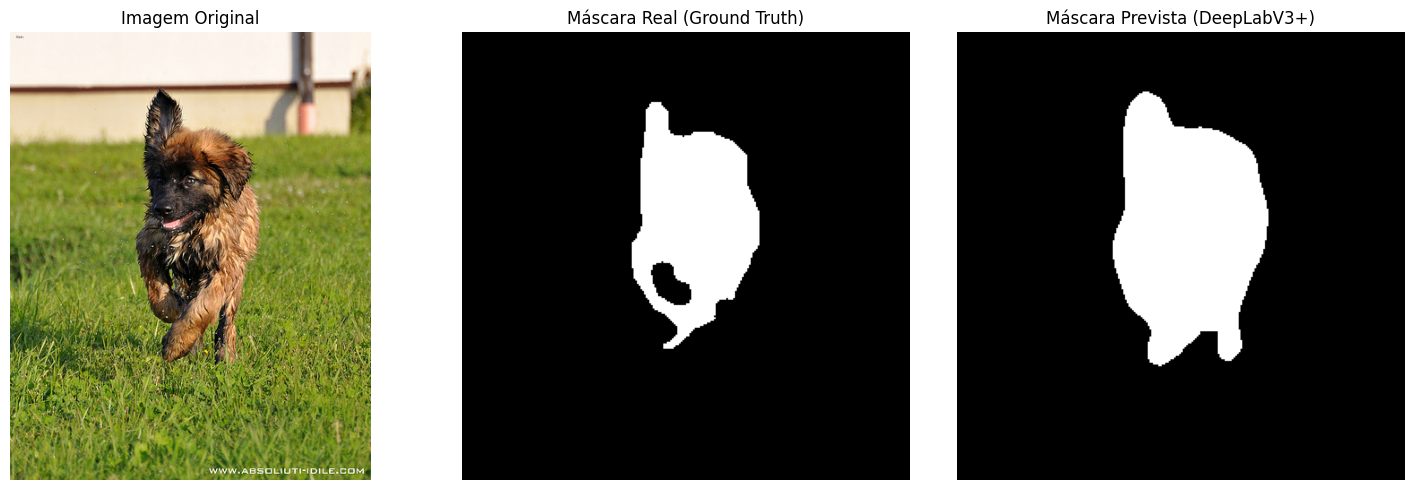


Processando imagem 2/5...
Tempo de inferência: 2.521 segundos
Classificação: Imagem segmentada em Pet (branco=1) vs Fundo/Borda (preto=0)


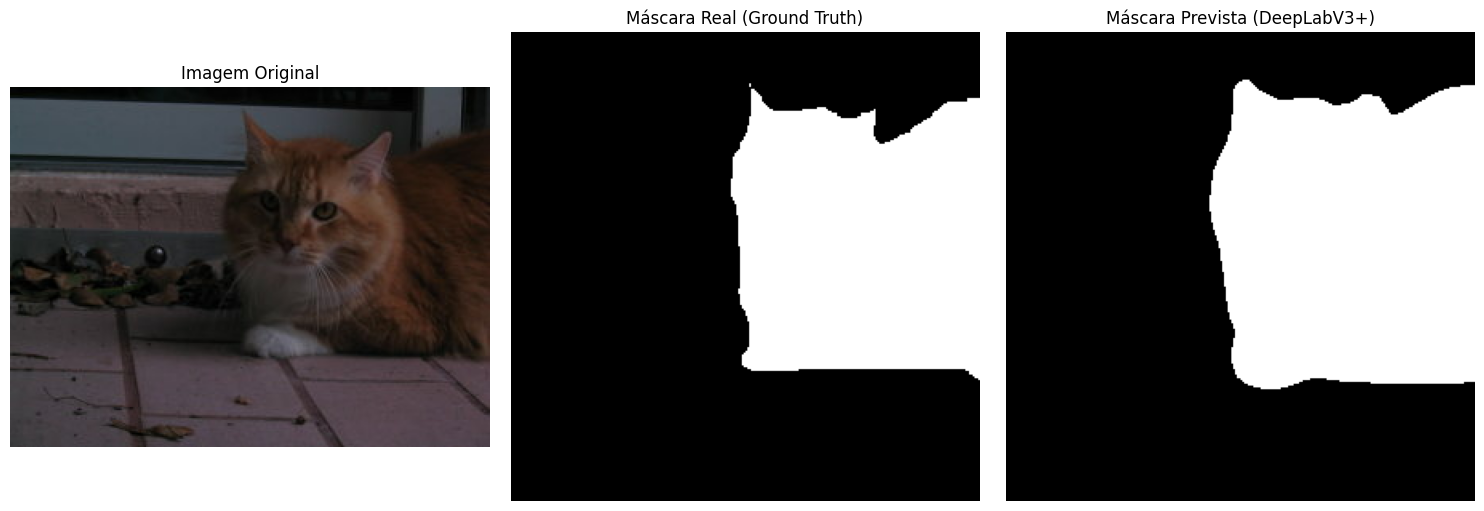


Processando imagem 3/5...
Tempo de inferência: 5.242 segundos
Classificação: Imagem segmentada em Pet (branco=1) vs Fundo/Borda (preto=0)


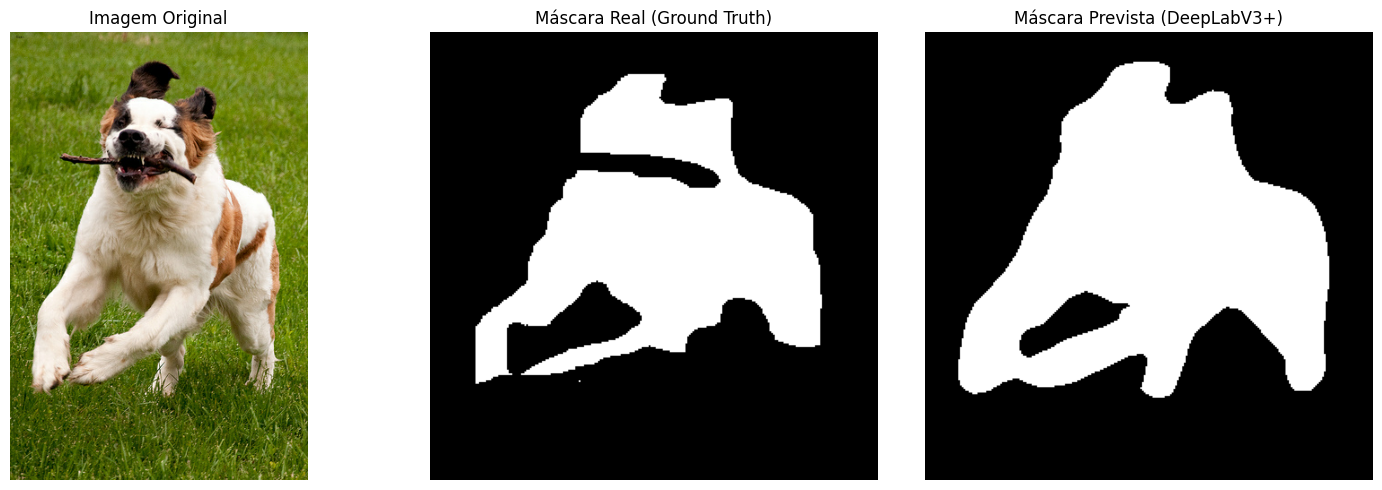


Processando imagem 4/5...
Tempo de inferência: 1.715 segundos
Classificação: Imagem segmentada em Pet (branco=1) vs Fundo/Borda (preto=0)


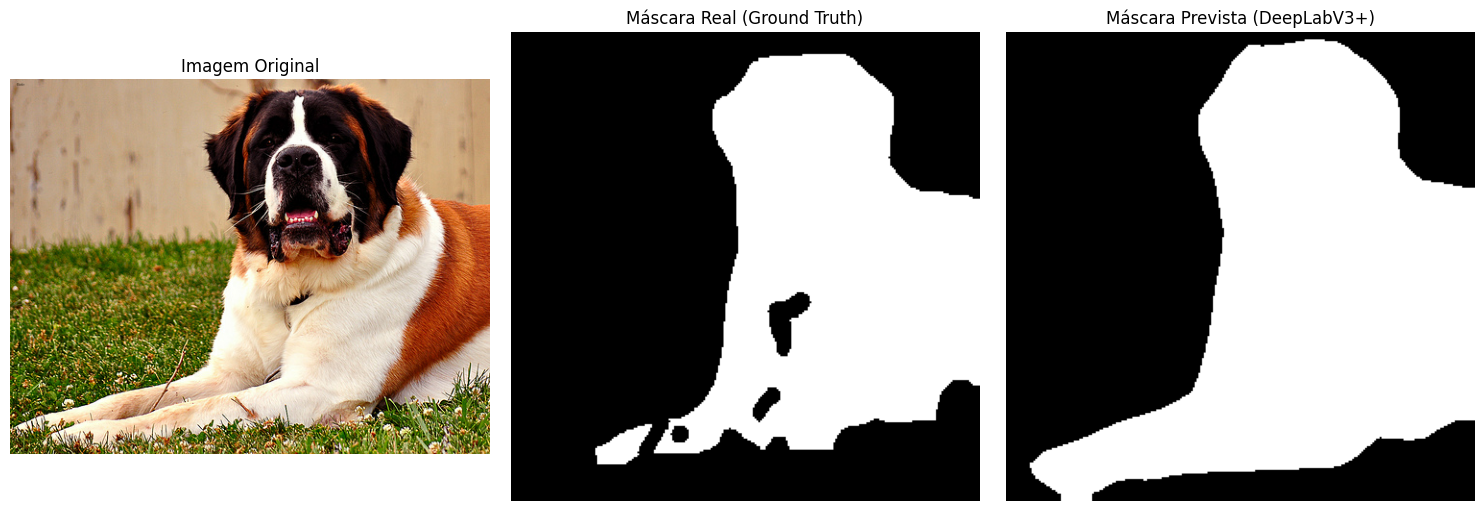


Processando imagem 5/5...
Tempo de inferência: 1.742 segundos
Classificação: Imagem segmentada em Pet (branco=1) vs Fundo/Borda (preto=0)


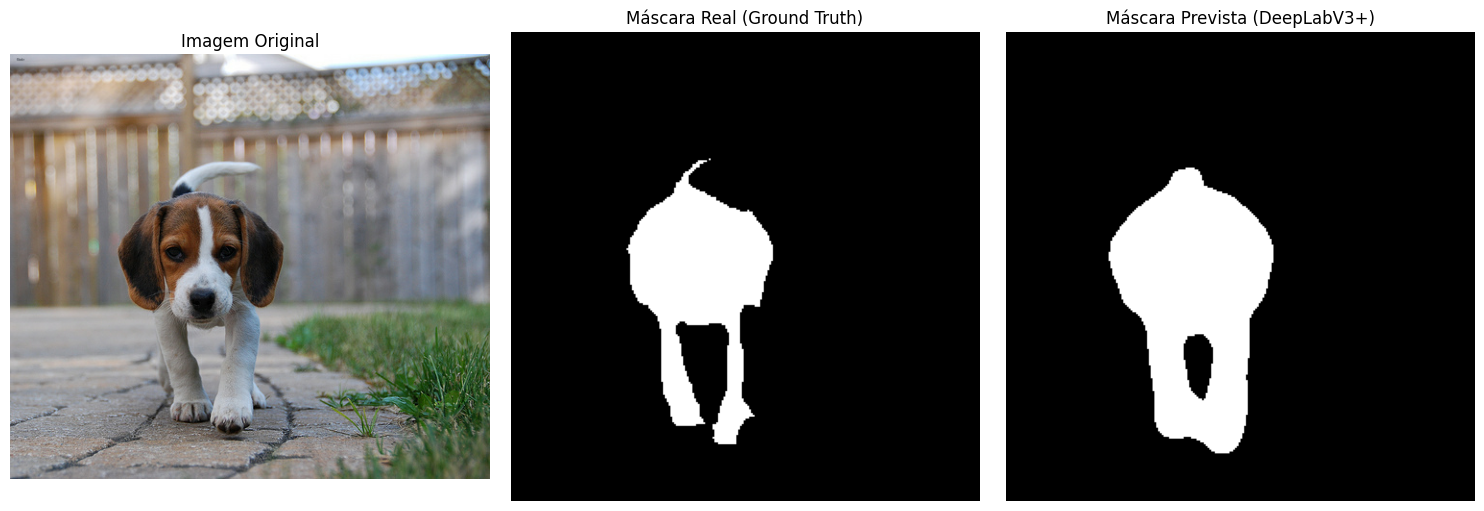

In [23]:
# --- Parte A: Execução e Visualização para N imagens ---
print(f"\n--- a) Execução e Visualização para {N_VISUALIZE} imagens ---")

# --- DEBUGGING/FIX ---
# Verifica o tipo da variável 'dataset' antes de usá-la no loop.
# tfds.load com split='test' DEVERIA retornar um tf.data.Dataset.
print(f"Verificando tipo da variável 'dataset' antes do loop: {type(dataset)}")

target_iterable = None # Inicializa a variável que será usada no loop

if isinstance(dataset, tf.data.Dataset):
    # Se 'dataset' já é o tipo correto, usa diretamente
    print("Variável 'dataset' é do tipo tf.data.Dataset (esperado).")
    target_iterable = dataset
elif isinstance(dataset, dict) and 'test' in dataset and isinstance(dataset['test'], tf.data.Dataset):
    # Se 'dataset' é um dict e contém a chave 'test' com o Dataset, usa ele
    print("Variável 'dataset' é um dict. Usando 'dataset['test']'.")
    target_iterable = dataset['test']
else:
    # Se não for nenhum dos casos esperados, informa o erro
    print("ERRO: A variável 'dataset' não é um objeto tf.data.Dataset ou um dicionário esperado.")
    print("      Verifique a execução da Célula 3 (carregamento do dataset).")
    # Interrompe a execução desta célula para evitar o AttributeError
    raise TypeError(f"Tipo inesperado para 'dataset': {type(dataset)}. Não é possível usar .take()")

# --- END DEBUGGING/FIX ---


count = 0
# Itera sobre o dataset correto (target_iterable) que verificamos acima
for data_point in target_iterable.take(N_VISUALIZE): # Usa a variável verificada/corrigida
    count += 1
    print(f"\nProcessando imagem {count}/{N_VISUALIZE}...")

    # Prepara os dados
    input_tensor, target_mask_tensor, original_pil = prepare_data(data_point)

    # Realiza a predição
    start_time = time.time()
    predicted_mask_np = predict(model, input_tensor, pet_indices_model)
    end_time = time.time()

    # Prepara para visualização
    target_mask_display = target_mask_tensor.cpu().numpy() # Máscara real já é 0/1

    print(f"Tempo de inferência: {end_time - start_time:.3f} segundos")
    print(f"Classificação: Imagem segmentada em Pet (branco={1}) vs Fundo/Borda (preto={0})")

    # Mostra os resultados
    display_list = [original_pil, target_mask_display, predicted_mask_np]
    titles = ['Imagem Original', 'Máscara Real (Ground Truth)', 'Máscara Prevista (DeepLabV3+)']
    display(display_list, titles)

## 6. Avaliação

In [24]:
# --- Parte B: Avaliação com Métricas ---
print(f"\n--- b) Avaliação do Modelo com Métricas (usando {EVAL_SAMPLE_SIZE} imagens) ---")

# Inicializa variáveis para acumular resultados da matriz de confusão
# Vamos calcular para a classe PET (classe 1) vs Resto (classe 0)
total_tp = 0 # True Positives (Pet previsto como Pet)
total_fp = 0 # False Positives (Fundo previsto como Pet)
total_fn = 0 # False Negatives (Pet previsto como Fundo)
total_tn = 0 # True Negatives (Fundo previsto como Fundo)
total_intersection_class = np.zeros(NUM_CLASSES_BINARY) # Para IoU por classe
total_union_class = np.zeros(NUM_CLASSES_BINARY)       # Para IoU por classe
total_pixels = 0

# Itera sobre o subconjunto de avaliação
for data_point in tqdm(eval_dataset, total=EVAL_SAMPLE_SIZE, desc="Avaliando"):
    # Prepara os dados
    input_tensor, target_mask_tensor, _ = prepare_data(data_point) # Imagem original não necessária aqui

    # Realiza a predição
    predicted_mask_np = predict(model, input_tensor, pet_indices_model) # Retorna numpy [H, W] com 0 ou 1

    # Converte máscara real para numpy
    target_mask_np = target_mask_tensor.cpu().numpy() # Numpy [H, W] com 0 ou 1

    # Garante que ambas as máscaras tenham o mesmo shape (devem ter por causa do resize)
    if predicted_mask_np.shape != target_mask_np.shape:
        # Se houver diferença mínima por arredondamento, redimensiona a predição
        from skimage.transform import resize
        predicted_mask_np = resize(predicted_mask_np, target_mask_np.shape,
                                   order=0, preserve_range=True, anti_aliasing=False).astype(np.int64)

    # Achata as máscaras para calcular a matriz de confusão mais facilmente
    target_flat = target_mask_np.flatten()
    predicted_flat = predicted_mask_np.flatten()

    # Calcula a matriz de confusão para a imagem atual
    # Labels são 0 (Fundo/Borda) e 1 (Pet)
    cm = confusion_matrix(target_flat, predicted_flat, labels=[0, 1])

    # Extrai TN, FP, FN, TP
    # cm = [[TN, FP],
    #       [FN, TP]]
    if cm.shape == (2, 2): # Verifica se ambas as classes 0 e 1 estão presentes
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1): # Caso onde só existe uma classe na imagem E na predição
         if np.unique(target_flat)[0] == 0: # Só Fundo
            tn, fp, fn, tp = cm[0][0], 0, 0, 0
         else: # Só Pet
            tn, fp, fn, tp = 0, 0, 0, cm[0][0]
    else: # Situação inesperada, ignora a imagem para as métricas de TP/FP etc.
        print(f"Aviso: Matriz de confusão inesperada: {cm.shape}. Pulando esta imagem para métricas cumulativas.")
        tn, fp, fn, tp = 0, 0, 0, 0 # Não adiciona nada
        continue # Pula para a próxima imagem

    # Acumula os valores
    total_tn += tn
    total_fp += fp
    total_fn += fn
    total_tp += tp
    total_pixels += target_flat.size

    # Acumula para IoU por classe
    for i in range(NUM_CLASSES_BINARY):
        intersection = np.sum((predicted_flat == i) & (target_flat == i))
        union = np.sum((predicted_flat == i) | (target_flat == i))
        total_intersection_class[i] += intersection
        total_union_class[i] += union

# --- Calcular Métricas Finais ---

# 1. Acurácia Pixel (Pixel Accuracy)
# (TP + TN) / Total de Pixels
pixel_accuracy = (total_tp + total_tn) / total_pixels if total_pixels > 0 else 0

# 2. Mean Intersection over Union (mIoU)
# IoU = Intersection / Union
# Calcula IoU para cada classe e depois a média
iou_per_class = np.zeros(NUM_CLASSES_BINARY)
for i in range(NUM_CLASSES_BINARY):
    iou_per_class[i] = total_intersection_class[i] / total_union_class[i] if total_union_class[i] > 0 else 0
mean_iou = np.nanmean(iou_per_class) # Usa nanmean para ignorar classes sem união (NaN)

# 3. Precisão (Precision) para a classe Pet (classe 1)
# TP / (TP + FP) - Dos pixels previstos como Pet, quantos realmente são?
precision_pet = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0

# 4. Revocação (Recall) ou Sensibilidade para a classe Pet (classe 1)
# TP / (TP + FN) - Dos pixels que realmente são Pet, quantos foram encontrados?
recall_pet = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0

# (Opcional) 5. F1-Score para a classe Pet
f1_score_pet = 2 * (precision_pet * recall_pet) / (precision_pet + recall_pet) if (precision_pet + recall_pet) > 0 else 0

print("\n--- Resultados da Avaliação ---")
print(f"Imagens Avaliadas: {EVAL_SAMPLE_SIZE}")
print(f"1. Acurácia Pixel Global (Pixel Accuracy): {pixel_accuracy:.4f}")
print(f"2. Mean IoU (mIoU):                       {mean_iou:.4f}")
print(f"   - IoU Classe 0 (Fundo/Borda):          {iou_per_class[0]:.4f}")
print(f"   - IoU Classe 1 (Pet):                  {iou_per_class[1]:.4f}")
print(f"3. Precisão (Precision) - Classe Pet:      {precision_pet:.4f}")
print(f"4. Revocação (Recall) - Classe Pet:        {recall_pet:.4f}")
print(f"   (Opcional) F1-Score - Classe Pet:       {f1_score_pet:.4f}")

print("\n--- Matriz de Confusão Agregada ---")
# Formato: [[TN, FP], [FN, TP]]
print(f"       Previsto Fundo | Previsto Pet")
print(f"Real Fundo:  {total_tn:^12d} | {total_fp:^12d}")
print(f"Real Pet  :  {total_fn:^12d} | {total_tp:^12d}")


--- b) Avaliação do Modelo com Métricas (usando 150 imagens) ---


Avaliando:   0%|          | 0/150 [00:00<?, ?it/s]


--- Resultados da Avaliação ---
Imagens Avaliadas: 150
1. Acurácia Pixel Global (Pixel Accuracy): 0.9231
2. Mean IoU (mIoU):                       0.8420
   - IoU Classe 0 (Fundo/Borda):          0.8909
   - IoU Classe 1 (Pet):                  0.7931
3. Precisão (Precision) - Classe Pet:      0.8136
4. Revocação (Recall) - Classe Pet:        0.9692
   (Opcional) F1-Score - Classe Pet:       0.8846

--- Matriz de Confusão Agregada ---
       Previsto Fundo | Previsto Pet
Real Fundo:    6174131    |    664380   
Real Pet  :     92061     |   2899828   


In [28]:
# (Código anterior da Célula 9 calculando as métricas... )
# total_tp, total_fp, total_fn, total_tn, total_pixels calculados
# pixel_accuracy, mean_iou, iou_per_class, precision_pet, recall_pet, f1_score_pet calculados

# --- Criar Tabela de Métricas com Pandas ---

print("\n--- Resultados da Avaliação (Tabela) ---")
print(f"Imagens Avaliadas: {EVAL_SAMPLE_SIZE}")

# Organiza os dados das métricas para o DataFrame
metrics_data = {
    "Métrica": [
        "Acurácia Pixel Global",
        "Mean IoU (mIoU)",
        "IoU Classe 0 (Fundo/Borda)",
        "IoU Classe 1 (Pet)",
        "Precisão (Precision) - Classe Pet",
        "Revocação (Recall) - Classe Pet",
        "F1-Score - Classe Pet"
    ],
    "Valor": [
        f"{pixel_accuracy:.4f}",
        f"{mean_iou:.4f}",
        f"{iou_per_class[0]:.4f}",
        f"{iou_per_class[1]:.4f}",
        f"{precision_pet:.4f}",
        f"{recall_pet:.4f}",
        f"{f1_score_pet:.4f}"
    ]
}

# Cria o DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Define a coluna 'Métrica' como índice para melhor visualização
metrics_df = metrics_df.set_index('Métrica')

# Exibe a tabela de métricas (o Colab renderiza DataFrames automaticamente)
# Changed from display(metrics_df, "Imagens") to:
from IPython.display import display
display(metrics_df)


# --- Criar Tabela da Matriz de Confusão com Pandas ---

print("\n--- Matriz de Confusão Agregada (Tabela) ---")

# Cria a matriz como lista de listas ou array numpy
# Formato: [[TN, FP], [FN, TP]]
cm_array = [[total_tn, total_fp],
            [total_fn, total_tp]]

# Cria o DataFrame da Matriz de Confusão
cm_df = pd.DataFrame(cm_array,
                     index=['Real: Fundo/Borda', 'Real: Pet'],
                     columns=['Previsto: Fundo/Borda', 'Previsto: Pet'])

# Exibe a tabela da matriz de confusão
display(cm_df)

# Você ainda pode imprimir os valores brutos se quiser
# print("\n--- Valores Brutos da Matriz de Confusão ---")
# print(f"TN: {total_tn}, FP: {total_fp}, FN: {total_fn}, TP: {total_tp}")


--- Resultados da Avaliação (Tabela) ---
Imagens Avaliadas: 150


,Valor
Métrica,
Acurácia Pixel Global,0.9231
Mean IoU (mIoU),0.8420
IoU Classe 0 (Fundo/Borda),0.8909
IoU Classe 1 (Pet),0.7931
Precisão (Precision) - Classe Pet,0.8136
Revocação (Recall) - Classe Pet,0.9692
F1-Score - Classe Pet,0.8846



--- Matriz de Confusão Agregada (Tabela) ---


,Previsto: Fundo/Borda,Previsto: Pet
Real: Fundo/Borda,6174131,664380
Real: Pet,92061,2899828
